In [ ]:
! python -m pip install -U scikit-image
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.0 MB 31.6 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
Mounted at /content/drive


In [ ]:
import sys
# user = 'aditya'
user = "pam"
# user = 'saurabh'

# define path to code 
if user == "pam":
  sys.path.append('/content/drive/MyDrive/Project/Codes/3d-super-res-cnn-master/d')
  print("using param's path")
elif user == 'saurabh':
  sys.path.append('/content/drive/MyDrive/809k/Project/Codes/3d-super-res-cnn-master/d')
  print("using saurabh's path")
else:
  sys.path.append('/content/drive/MyDrive/ENPM809K/Project/Codes/3d-super-res-cnn-master/d')

using param's path


In [ ]:
import torch
import numpy
import matplotlib.pyplot as plt
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import os
import numpy as np
import cv2 as cv
import random
import math
from sklearn.utils import shuffle
import pdb
import re
import glob

import data_reader as reader
import networks as nets
import utils
import params

SHOW_IMAGES = False 
 
params.show_params()   

if user == 'pam': 
  data_reader = reader.DataReader('/content/drive/MyDrive/Project/custom_h_and_w_output', './data/validation', './data/test')
elif user == 'saurabh': 
  data_reader = reader.DataReader('/content/drive/MyDrive/809k/Project/custom_h_and_w_output', './data/validation', './data/test')
else:
  data_reader = reader.DataReader('/content/drive/MyDrive/ENPM809K/Project/custom_h_and_w_output', './data/validation', './data/test')



Instructions for updating:
non-resource variables are not supported in the long term







The configuration file is:
scale = 2 
folder base name = ../cnn-3d/3d-images 
folder name = 00001_0004 
image extension = png 
interpolation method = 4 
num epochs = 45 
loss = 1 
learning rate = 0.001 
dim patch = _d_14_7_2 
kernel size = 5 
folder data size = ./data_ckpt/ 
num_channels  = 1 





Files were not sorted. Sorting files in utils.py using the following lambda function

(1, 32, 32, 1)


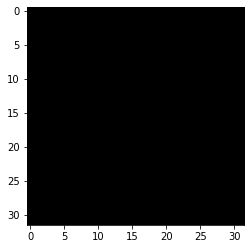

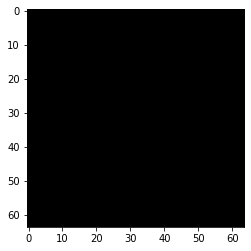

In [ ]:
# #code no use why use ?
#Target and input image are same now
import os
import cv2
image , target = data_reader.get_next_batch_train(400,1)
print(image.shape)
import matplotlib.pyplot as plt
plt.imshow(image[0,:,:,0],cmap='gray')
plt.show()
plt.imshow(target[0,:,:,0],cmap='gray')
plt.show()

# image = image[0]
# print(image.shape)

# image = np.reshape(image ,  (1,32,64))
# image = image[0]
# #reshape the input 
# # image = numpy.resize(image , (1 , 32,32))
# image = cv2.resize(image,(32,32))
# plt.imshow(image,cmap = 'gray')
# plt.show()

In [ ]:
from custom_network_d import Net
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net()
model = model.to(device)
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (ELU1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (ELU2): ELU(alpha=1.0)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (ELU3): ELU(alpha=1.0)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (ELU4): ELU(alpha=1.0)
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (ELU5): ELU(alpha=1.0)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (ELU6): ELU(alpha=1.0)
  (conv7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (ELU7): ELU(alpha=1.0)
  (conv8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (ELU8): ELU(alpha=1.0)
  (conv9): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (ELU9): ELU(alpha=1.0)
  (depth2space): PixelShuffle(upscale_factor=2)
)


In [ ]:
#training
params.folder_data = "/content/drive/MyDrive/809k/Project/Codes/3d-super-res-cnn-master/d/data_ckpt"
batch_size = 128 

#loss
if params.LOSS == params.L1_LOSS:
	loss = nn.L1Loss()
if params.LOSS == params.L2_LOSS:
	loss = torch.nn.MSELoss


#adaptive learing rate
lr = params.learning_rate 

#optimizer
optimizer = torch.optim.Adam(model.parameters() , lr = params.learning_rate)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
lambda1 = lambda epoch: 0.99 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

print('the number of images is: ', data_reader.num_train_images)
print("Number of Epochs is: ", params.num_epochs)
loss_after_every_epoch = []
ssim_after_every_epoch = []
psnr_after_every_epoch = []
predicted_images = np.zeros((len(data_reader.train_images_in),64,64,1))

for epoch in range(params.num_epochs):
  print("Doing Epoch: " , epoch)
  batch_loss = 0
  num_images = 0
  num_iterations = math.floor(data_reader.num_train_images / batch_size)
  print("Doing Epoch: " , epoch)
  batch_loss = 0
  num_images = 0
  num_iterations = math.floor(data_reader.num_train_images / batch_size)
  print('the number of iterations is %d' % num_iterations)
  ssim_epoch = 0
  psnr_epoch = 0


  for i in range(0, num_iterations): 
    input_, target_  = data_reader.get_next_batch_train(i, batch_size)
    num_images += batch_size
    input_ = np.reshape(input_ , (batch_size, -1,32,32))
    input_ = torch.from_numpy(input_)
    
    input_ = input_.to(device,dtype = torch.float)

    target_ = np.reshape(target_ , (batch_size ,-1,64,64))
    target_ = torch.from_numpy(target_)
    target_ = target_.to(device)

    output = model(input_)
    loss_ = loss(output , target_)

    optimizer.zero_grad()
    loss_.backward()
    optimizer.step()
    
    
    # ssim_batch, psnr_batch = utils.compute_ssim_psnr_batch(np.round(output.detach().cpu().numpy()), np.round(target_.detach().cpu().numpy()))
    output = output.cpu().data.numpy()
    target_ = target_.cpu().data.numpy()
    if epoch == params.num_epochs-1:
      predicted_images[i*128:(i+1)*128, :, :, :] = output.reshape(batch_size,64,64,1)
    ssim_batch, psnr_batch = utils.compute_ssim_psnr_batch(np.round(output.reshape(batch_size,64,64,1)), np.round(target_.reshape(batch_size,64,64,1)))
    
    batch_loss += loss_ * batch_size
    ssim_epoch += ssim_batch
    psnr_epoch += psnr_batch
    print("Epoch/Iteration {}/{} ...".format(epoch, i), "Training loss: {:.4f}  ssim: {:.4f} psnr: {:.4f}".
			  format(batch_loss/num_images, ssim_epoch/num_images, psnr_epoch/num_images), "Learning rate:  {:.8f}".
			  format(optimizer.param_groups[0]["lr"]))

    # print("Epoch/Iteration {}/{} ...".format(epoch, i), "Training loss: {:.4f}  ".format(batch_loss/num_images) , "Learning rate:  {:.8f}".format(lr))
  scheduler.step()
  loss_after_every_epoch.append(batch_loss)
  if user == 'pam':
    PATH = "/content/drive/MyDrive/Project/Codes/3d-super-res-cnn-master/d/custom_data_ckpt/"
  elif user == 'aditya':
    PATH = "/content/drive/MyDrive/ENPM809K/Project/Codes/3d-super-res-cnn-master/d/custom_data_ckpt/"
  else:
    PATH = "/content/drive/MyDrive/809k/Project/Codes/3d-super-res-cnn-master/d/custom_data_ckpt/"


  epoch = "Checkpoint_" + str(epoch) + ".pth" 
  PATH = PATH + epoch
  print("saving checkpoint at: ", PATH )
  torch.save(model , PATH)
  ssim_epoch_normalized = ssim_epoch/num_images
  ssim_after_every_epoch.append(ssim_epoch_normalized) 
  psnr_after_every_epoch.append(psnr_epoch)


the number of images is:  10240
Number of Epochs is:  45
Doing Epoch:  0
Doing Epoch:  0
the number of iterations is 80


/usr/local/lib/python3.8/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


Epoch/Iteration 0/0 ... Training loss: 1.6474  ssim: 0.9626 psnr: 61.3217 Learning rate:  0.00100000
Epoch/Iteration 0/1 ... Training loss: 4.5573  ssim: 0.8953 psnr: 49.7336 Learning rate:  0.00100000
Epoch/Iteration 0/2 ... Training loss: 7.8138  ssim: 0.8150 psnr: 41.6715 Learning rate:  0.00100000
Epoch/Iteration 0/3 ... Training loss: 10.2673  ssim: 0.7508 psnr: 36.0876 Learning rate:  0.00100000
Epoch/Iteration 0/4 ... Training loss: 11.9706  ssim: 0.7010 psnr: 32.6593 Learning rate:  0.00100000
Epoch/Iteration 0/5 ... Training loss: 12.9304  ssim: 0.6713 psnr: 30.4968 Learning rate:  0.00100000
Epoch/Iteration 0/6 ... Training loss: 13.4775  ssim: 0.6519 psnr: 29.0093 Learning rate:  0.00100000
Epoch/Iteration 0/7 ... Training loss: 14.0056  ssim: 0.6344 psnr: 27.8643 Learning rate:  0.00100000
Epoch/Iteration 0/8 ... Training loss: 14.3551  ssim: 0.6250 psnr: 27.0149 Learning rate:  0.00100000
Epoch/Iteration 0/9 ... Training loss: 14.4392  ssim: 0.6236 psnr: 26.3993 Learning r

[]

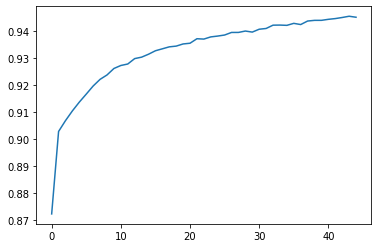

In [ ]:
plt.plot(ssim_after_every_epoch)
plt.plot()

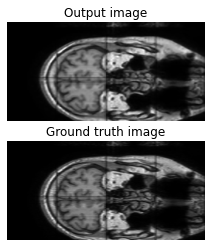

In [ ]:
import matplotlib.pyplot as plt

img = np.zeros((128,256))
for i in range(2):
  for j in range(4):
    img[i*64:(i+1)*64, j*64:(j+1)*64] = predicted_images[512+i*4+j, :,:,0]

img1 = np.zeros((128,256))
for i in range(2):
  for j in range(4):
    img1[i*64:(i+1)*64, j*64:(j+1)*64] = data_reader.train_images_gt[512+i*4+j, :,:,0]
plt.subplot(2,1,1)
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.title('Output image')
plt.subplot(2,1,2)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.title('Ground truth image')
plt.show()